# Confidence intervals and A/B testing

Ryan Reece     
2018-02-26

## Introduction

TODO.

In [64]:
## imports
import csv

import numpy as np
np.random.seed(777) # for DEBUG

import matplotlib
#matplotlib.use("Agg") # suppress the python rocketship icon popup
import matplotlib.pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['font.size'] = 18

import scipy.stats as stats
import pandas as pd

## Generate some toy data

In [142]:
#______________________________________________________________________________
def generate_data(n_dim=2, n_class=2, n_points=400, purities=None):

    assert n_dim == 2
    assert n_class in (2, 3, 4)

    ## setup purities
    if purities == None:
        assert n_class > 0
        purity_share = 1.0/n_class
        purities = tuple([purity_share]*n_class)
    assert sum(purities) == 1.0
    
    ## HACK: hardcoded
    ## setup variables
    var_names = dict()
    label_names = dict()
    means = dict()
    covs = dict()
    if n_dim == 2:
        var_names[0] = 'x'
        var_names[1] = 'y'
        label_names[0] = 0
        label_names[1] = 1
        label_names[2] = 2
        label_names[3] = 3
        means[0] = [0.0, 0.0]
        means[1] = [1.0, 1.0]
        means[2] = [1.0, -1.0]
        means[3] = [0.8, -1.5]
        covs[0]  = [[0.1, 0.0], [0.0, 0.1]]
        covs[1]  = [[0.3, 0.0], [0.0, 0.1]]
        covs[2]  = [[0.02, 0.0], [0.0, 0.02]]
        covs[3]  = [[0.02, 0.0], [0.0, 0.02]]
    elif n_dim == 3:
        pass
    
    ## setup csv header
    data_header = list()
    for i_dim in range(n_dim):
        data_header.append( var_names[i_dim] )
    data_header.append('label')
    
    ## generate data for each class
    data_gen = list()
    for i_class in range(n_class):
        data_for_class = list()
        _p = purities[i_class]
        _n = int(round(n_points*_p))
        label_name = label_names[i_class]
        for rep in np.random.multivariate_normal(means[i_class], covs[i_class], _n):
            rep_list = list(rep)
            rep_list.append(label_name)
            data_for_class.append(rep_list)
        data_gen.extend(data_for_class)
        
    np.random.shuffle(data_gen)
    data = list()
    data.append(data_header)
    data.extend(data_gen)
    return data


#______________________________________________________________________________
def save_to_csv(data, csvfile='out.csv'):
    with open(csvfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(data)
        f.close()

#==============================================

csvfile = 'toy2d.csv'
print 'Generating data'
data = generate_data(n_dim=2, n_class=3, n_points=500, purities=(0.5, 0.3, 0.2))
print 'Saving csv'
save_to_csv(data, csvfile)
print 'Saved data to %s' % csvfile

Generating data
Saving csv
Saved data to toy2d.csv


In [143]:
df = pd.read_csv('toy2d.csv')

In [144]:
df.head()

,x,y,label
0,0.087363,-0.223797,0
1,-0.250863,-0.220664,0
2,1.051412,1.094912,1
3,1.730965,0.890139,1
4,0.165255,-0.341360,0


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
x        500 non-null float64
y        500 non-null float64
label    500 non-null int64
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


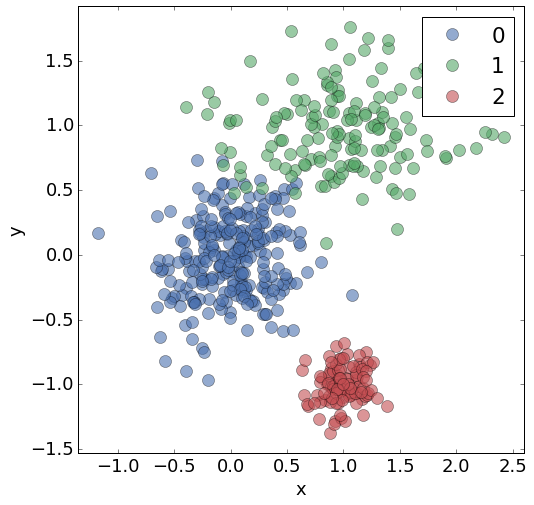

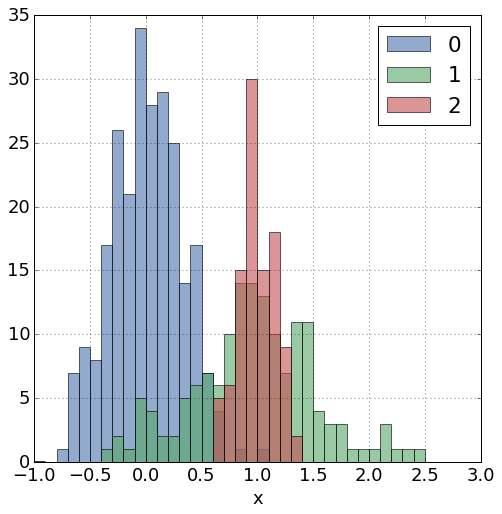

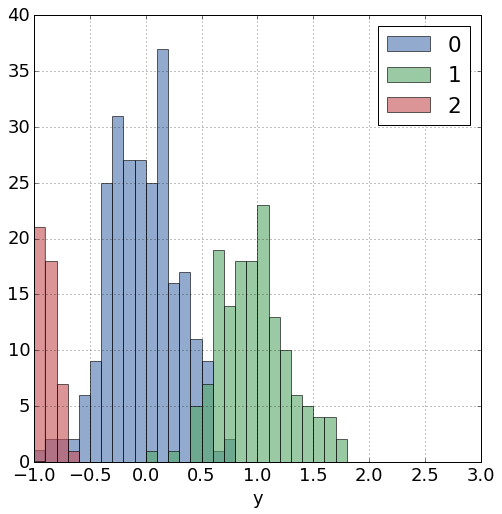

In [146]:
#______________________________________________________________________________
def scatter_plot(df, x, y):
    df_groupby = df.groupby('label')
    colors = pd.tools.plotting._get_standard_colors(len(df_groupby), color_type='default')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for i_grp, group in enumerate(df_groupby):
        label, df_group = group
        ax.plot(df_group[x], df_group[y], marker='o', linestyle='', ms=12, label=label, color=colors[i_grp], alpha=0.6)
    plt.xlabel(x)
    plt.ylabel(y)
    ax.legend(numpoints=1, loc='upper right')
    plt.show()
    return fig, ax

#______________________________________________________________________________
def histogram(df, var, by, bins=10):
    group_labels = df[by].unique()
    group_labels.sort()
    colors = pd.tools.plotting._get_standard_colors(len(group_labels), color_type='default')
    fig, ax = plt.subplots()
    for i_grp, label in enumerate(group_labels):
        df[df[by]==label][var].hist(bins=bins, label=str(label), color=colors[i_grp], alpha=0.6)
    plt.xlabel(var)
    ax.legend(loc='upper right')
    plt.show()
    return fig, ax

#==============================================
fig, ax = scatter_plot(df, x='x', y='y')
fig, ax = histogram(df, var='x', by='label', bins=np.arange(-1, 3, 0.1))
fig, ax = histogram(df, var='y', by='label', bins=np.arange(-1, 3, 0.1))

## $z$ statistic

TODO:

-   normally distributed
-   used when variance is known

$Z = \frac{{\bar{X}}-\mu}{{\sigma \: /\sqrt{n}}}$


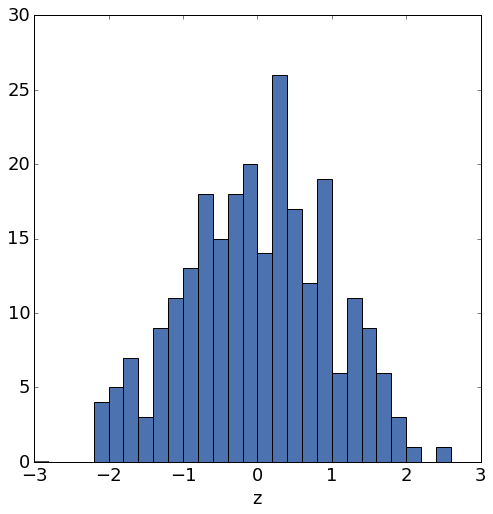

In [184]:
xdata0 = df[df['label']==0]['x']
zscores = stats.zscore(xdata0)
stuff = plt.hist(zscores, bins=np.arange(-3, 3, 0.2))
stuff1 = plt.xlabel('z')

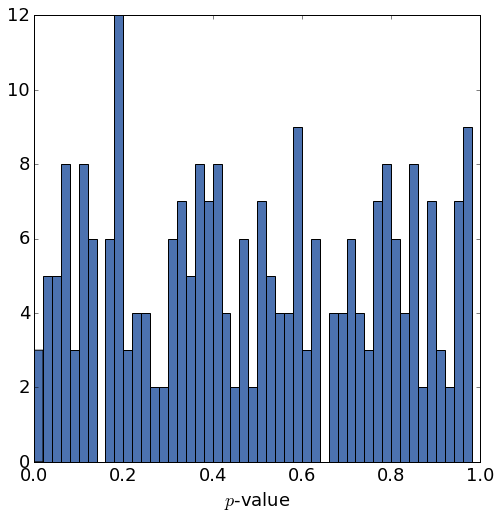

In [195]:
#p_values = stats.norm.sf(abs(zscores)) # one-sided
#p_values2 = stats.norm.sf(abs(zscores))*2 # twosided
p_values = stats.norm.sf(zscores)
stuff = plt.hist(p_values, bins=np.arange(0.0, 1.0, 0.02))
stuff1 = plt.xlabel('$p$-value')

## $t$ statistic

The [$t$-test](https://en.wikipedia.org/wiki/Student%27s_t-test) is a statistical hypothesis test can be used to determine if sets of data are significantly different from each other.  A $t$-test is most commonly used when the test statistic, $t$, would follow a normal distribution if the value of a scaling term were known. When the scaling term is unknown and is replaced by an estimate based on the data, the test statistic (under certain conditions) follows a [Student's $t$ distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).

$t={\frac {Z}{s}}={\frac {\left({\bar {X}}-\mu \right)\left/\left({\frac {\sigma }{\sqrt {n}}}\right)\right.}{s}}$

TODO:

-   used when variance is unknown

A $t$-statistic is often used to test a null hypothesis about two means; most often, it tests the hypothesis that two means are equal, or that the difference between them is zero.  In this case, [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) is used. In Welch's t-test, there are two different data samples which in general have different, unknown variances.

$t = {\;\overline {X}_{1}-\overline {X}_{2}\; \over {\sqrt  {\;{s_{1}^{2} \over N_{1}}\;+\;{s_{2}^{2} \over N_{2}}\quad }}}\,$

In [208]:
result = stats.ttest_1samp(xdata0, 0.0)
t = result.statistic
p = result.pvalue
print 't = %.5g' % (t)
print 'p = %.5g' % (p)

t = 0.078716
p = 0.93732


In [210]:
xdata1 = df[df['label']==1]['x']
result = stats.ttest_ind(xdata0, xdata1)
t = result.statistic
p = result.pvalue
print 't = %.5g' % (t)
print 'p = %.5g' % (p)

t = -22.249
p = 7.6698e-72


In [211]:
xdata2 = df[df['label']==2]['x']
result = stats.ttest_ind(xdata1, xdata2)
t = result.statistic
p = result.pvalue
print 't = %.5g' % (t)
print 'p = %.5g' % (p)

t = -0.3883
p = 0.69812


For [example](http://www.theseashore.org.uk/theseashore/Stats%20for%20twits/T%20Test.html), we could test whether men and women have the same average weight.

Let's say we have series of measurements of weight in kg and sex (0=male, 1=female):

TODO

Abstractly, a $t$ statistic with $k$ degrees of freedom can be constructed by dividing a normally distributed random variable by an independent $\chi^{2}_{k}$ distribution:

$t_k = \frac{Z_0}{\sqrt{\left(\sum_i^k Z_i^2\right) / k}} \sim \frac{N(0, 1)}{\sqrt{\chi^{2}_{k} / k}}$

For more details, see [Allwood (2008)](https://secure-media.collegeboard.org/apc/ap05_stats_allwood_fin4prod.pdf).

## $\chi^2$ statistic

Often we are interested in measuring some rate of interest, $\rho \in [0, 1]$, that can be thought of as a success rate or conversion rate: the fraction of events that did something of interest.  In the framework of A/B-testing, not only do we want to measure a parameter of interest, but we want to see if it is *significantly* different between two samples: $A$ and $B$. Often sample $A$ is thought of as the original or control version, and in sample $B$, we have made some kind of systematic change, and we want to test if that *significantly* changes $\rho$.

TODO:

-   $\chi^2$ uses categorical/binned data

**Following the blitzresults.com example**

Working out the example [here](http://www.blitzresults.com/en/ab-tests/) with the $\chi^2$ method.

In [1]:
##=============================================================================
## USER INPUT
##=============================================================================
N_A1 =  960.  # not converted, sample A
N_A2 =   40.  # converted, sample A
N_B1 = 1120.  # not converted, sample B
N_B2 =   80.  # converted, sample B

First, let's calculate the conversion rate from the total number of events and conversions.

In [2]:
#______________________________________________________________________________
def a_b_test_conversion_rate(N_A1, N_A2, N_B1, N_B2):
    N_1 = N_A1 + N_B1
    N_2 = N_A2 + N_B2
    rho = N_2/(N_1+N_2)
    return rho

rho = a_b_test_conversion_rate(N_A1, N_A2, N_B1, N_B2)
print 'Conversion rate, rho = %.5g' % (rho)

Conversion rate, rho = 0.054545


In general, when calculating $\chi^2$ for comparing the goodness of fit of a model to the observed data:

$\chi^2 = \sum_{i} \frac{(O_i - E_i)^2}{E_i}$

Assuming the conversion rate is the same among samples $A$ and $B$,

$\chi^2 = \frac{(N_{A1} - N_{A}*(1-\rho))^2}{N_{A}*(1-\rho)} + \frac{(N_{A2} - N_{A}*\rho)^2}{N_{A}*\rho} + \frac{(N_{B1} - N_{B}*(1-\rho))^2}{N_{B}*(1-\rho)} + \frac{(N_{B2} - N_{B}*\rho)^2}{N_{B}*\rho}$

In [3]:
def a_b_test_chi2(N_A1, N_A2, N_B1, N_B2):
    N_A = N_A1 + N_A2
    N_B = N_B1 + N_B2
    N_1 = N_A1 + N_B1
    N_2 = N_A2 + N_B2
    rho = N_2/(N_1+N_2)
    chi2 = ((N_A1 - N_A*(1-rho))**2)/(N_A*(1-rho)) + \
           ((N_A2 - N_A*rho)**2)/(N_A*rho) + \
           ((N_B1 - N_B*(1-rho))**2)/(N_B*(1-rho)) + \
           ((N_B2 - N_B*rho)**2)/(N_B*rho)
    ## checking the chi2 term-by-term:
    #print '%.5g' % (((N_A1 - N_A*(1-rho))**2)/(N_A*(1-rho)))
    #print '%.5g' % (((N_A2 - N_A*rho)**2)/(N_A*rho))
    #print '%.5g' % (((N_B1 - N_B*(1-rho))**2)/(N_B*(1-rho)))
    #print '%.5g' % (((N_B2 - N_B*rho)**2)/(N_B*rho))
    return chi2
        
chi2 = a_b_test_chi2(N_A1, N_A2, N_B1, N_B2)
print 'chi2 = %.5g' % (chi2)

chi2 = 7.5214


Comparing this $\chi^2$ value with a [table of critical values](https://home.ubalt.edu/ntsbarsh/Business-stat/StatistialTables.pdf), with degrees of freedom = 1,
shows that the corresponding $p$-value for $\chi^2$ = 7.52 to be smaller than 1%, which corresponds to $\chi^2$ = 6.635.  Note that degrees of freedom is 1 because there is only one free parameter in the model: $\rho$.

![](media/critical-values-of-chi2.png)

Instead of looking up the $p$-value in a table, we can also calculate it with `scipy.stats`:

In [4]:
obs = [[N_A1, N_A2], [N_B1, N_B2]]
chi2, p, dof, ex = stats.chi2_contingency(obs, correction=False)
print 'chi2 = %.5g' % (chi2)
print 'p    = %.5g' % (p)
print 'dof  = %.5g' % (dof)
print 'expected = %s' % (ex)

chi2 = 7.5214
p    = 0.0060971
dof  = 1
expected = [[  945.45454545    54.54545455]
 [ 1134.54545455    65.45454545]]


So the $p$-value is 0.6%, rather significant.

Above, `correction=False` means that we do not do the [Yates' correction](https://en.wikipedia.org/wiki/Yates%27s_correction_for_continuity).

**Following the elegantthemes.com example**

Working out another example [here](https://www.elegantthemes.com/blog/resources/how-to-determine-statistical-significance-when-ab-testing-with-divi-leads) with the $\chi^2$ method.

In [5]:
##=============================================================================
## USER INPUT
##=============================================================================
N_A1 = 976.  # not converted, sample A
N_A2 =  43.  # converted, sample A
N_B1 = 992.  # not converted, sample B
N_B2 =  34.  # converted, sample B

In [6]:
obs = [[N_A1, N_A2], [N_B1, N_B2]]
chi2, p, dof, ex = chi2_contingency(obs, correction=False)
print 'chi2 = %.5g' % (chi2)
print 'p    = %.5g' % (p)
print 'dof  = %.5g' % (dof)
print 'expected = %s' % (ex)

chi2 = 1.1581
p    = 0.28186
dof  = 1
expected = [[ 980.63178484   38.36821516]
 [ 987.36821516   38.63178484]]


Having a $p$-value of 28%, I wouldn't say there is a significant difference in samples $A$ and $B$.

## See also

References:

-   [Wikipedia: Lady tasting tea](https://en.wikipedia.org/wiki/Lady_tasting_tea)
-   [Wikipedia: Student's $t$-test](https://en.wikipedia.org/wiki/Student%27s_t-test)
-   [Wikipedia: Welch's $t$-test](https://en.wikipedia.org/wiki/Welch%27s_t-test)
-   [Wikipedia: Binomial proportion confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval)
-   [Wikipedia: Rule of three](https://en.wikipedia.org/wiki/Rule_of_three_%28statistics%29)
-   [Tables of critical values](https://home.ubalt.edu/ntsbarsh/Business-stat/StatistialTables.pdf)
-   [Leemis & McQueston (2008). Univariate Distribution Relationships.](http://www.stat.rice.edu/~dobelman/courses/texts/leemis.distributions.2008amstat.pdf)

Illuminating discussions:

-   [KhanAcademy: hypothesis testing videos](https://www.khanacademy.org/math/statistics-probability/significance-tests-one-sample/more-significance-testing-videos/v/large-sample-proportion-hypothesis-testing)
-   [Quora: What is an intuitive explanation for how the $t$, $z$, and $\chi^2$-distributions are related?](https://www.quora.com/What-is-an-intuitive-explanation-for-how-the-t-distribution-normal-distribution-F-distribution-and-Chi-square-distribution-relate-to-each-other-Why-do-all-these-different-distributions-exist-and-when-do-we-use-each-in-statistical-testing/answer/Chandrima-Das)
-   [Quora: How can I do an A/B test in Python?](https://www.quora.com/How-can-I-do-an-A-B-test-in-Python)
-   [Allwood, M. (2008). The Satterthwaite Formula for degrees of freedom in the two-sample $t$-test.](https://secure-media.collegeboard.org/apc/ap05_stats_allwood_fin4prod.pdf)
-   [A/B Testing Statistics: An intuitive guide for non-mathematicians](https://conversionsciences.com/blog/ab-testing-statistics/)

Some worked examples:

-   [Stats notes at The Seashore](http://www.theseashore.org.uk/theseashore/Stats%20for%20twits/T%20Test.html)
-   [$\chi^2$-test for A/B-tests at blitzresults.com](http://www.blitzresults.com/en/ab-tests)
-   [$\chi^2$-test for A/B-tests at elegantthemes.com](https://www.elegantthemes.com/blog/resources/how-to-determine-statistical-significance-when-ab-testing-with-divi-leads)
-   [$\chi^2$-test for independence (biology example)](https://www.biologyforlife.com/x2-test-for-independence.html)
-   [2-sample $t$-test for A/B-tests in R](https://rexplorations.wordpress.com/2015/08/13/hypothesis-tests-2-sample-tests-ab-tests/)
-   [A/B Testing with Hierarchical Models in Python (Bayesian)](https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/)

Toolkits:

-   [scipy.stats](https://docs.scipy.org/doc/scipy-0.18.0/reference/stats.html)
-   [scipy.stats.ttest_1samp](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.ttest_1samp.html#scipy.stats.ttest_1samp)
-   [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)
-   [scipy.stats.zscore](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.zscore.html#scipy.stats.zscore)

Maybes:

-   [are-different-p-values-for-chi-squared-and-z-test-expected](https://stats.stackexchange.com/questions/141547/are-different-p-values-for-chi-squared-and-z-test-expected-for-testing-differenc)
-   [a-b-tests-z-test-vs-t-test-vs-chi-square-vs-fisher-exact-test](https://stats.stackexchange.com/questions/178854/a-b-tests-z-test-vs-t-test-vs-chi-square-vs-fisher-exact-test)
-   [difference-between-ttest-chi-square](https://sciencing.com/difference-between-ttest-chi-square-8225095.html)



## Taken from Mark

In [7]:
#from statsmodels.stats.proportion import proportions_ztest
#
#count = np.array([4031, 1777])
#nobs = np.array([202672, 114128])
#proportions_ztest(count,nobs,value=None, alternative='two-sided')
## stat, pval =proportions_ztest(count, nobs, value)
## print('%.80f' % pval)

In [8]:
#import statsmodels.stats.api as sms
#es = sms.proportion_effectsize(0.019889, 0.015570)
#sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)